In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from google.colab import files
from google.colab import drive
from tensorflow.keras.layers import TimeDistributed

# 1. Uploading Files

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_train = pd.read_csv("/content/drive/My Drive/TA/demandData/train.csv")
df_test = pd.read_csv("/content/drive/My Drive/TA/demandData/test.csv")

In [ ]:
df_train.index = pd.to_datetime(df_train['date'])
df_train.drop('date', axis=1, inplace=True)
df_test.index = pd.to_datetime(df_test['date'])
df_test.drop('date', axis=1, inplace=True)

In [ ]:
df_train.head()

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


In [ ]:
from itertools import product, starmap

def storeitems():
    return product(range(1,51), range(1,11))


def storeitems_column_names():
    return list(starmap(lambda i,s: f'item_{i}_store_{s}_sales', storeitems()))


def sales_by_storeitem(df):
    ret = pd.DataFrame(index=df.index.unique())
    for i, s in storeitems():
        ret[f'item_{i}_store_{s}_sales'] = df[(df['item'] == i) & (df['store'] == s)]['sales'].values
    return ret

In [ ]:
df_train = sales_by_storeitem(df_train)
df_test['sales'] = np.zeros(df_test.shape[0])
df_test = sales_by_storeitem(df_test)

<ipython-input-6-e4dda4c1d94d>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  ret[f'item_{i}_store_{s}_sales'] = df[(df['item'] == i) & (df['store'] == s)]['sales'].values


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2013-01-01 to 2017-12-31
Columns: 500 entries, item_1_store_1_sales to item_50_store_10_sales
dtypes: int64(500)
memory usage: 7.0 MB


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 90 entries, 2018-01-01 to 2018-03-31
Columns: 500 entries, item_1_store_1_sales to item_50_store_10_sales
dtypes: float64(500)
memory usage: 352.3 KB


In [ ]:
# make sure all column names are the same and in the same order
col_names = list(zip(df_test.columns, df_train.columns))
for cn in col_names:
    assert cn[0] == cn[1]

In [ ]:
df_test['is_test'] = np.repeat(True, df_test.shape[0])
df_train['is_test'] = np.repeat(False, df_train.shape[0])
df_total = pd.concat([df_train, df_test])
df_total.info()

<ipython-input-11-790e1f90b4bf>:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test['is_test'] = np.repeat(True, df_test.shape[0])
<ipython-input-11-790e1f90b4bf>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train['is_test'] = np.repeat(False, df_train.shape[0])


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1916 entries, 2013-01-01 to 2018-03-31
Columns: 501 entries, item_1_store_1_sales to is_test
dtypes: bool(1), float64(500)
memory usage: 7.3 MB


In [ ]:
train = pd.read_csv("/content/drive/My Drive/TA/demandData/train.csv", parse_dates=['date'])
test = pd.read_csv("/content/drive/My Drive/TA/demandData/test.csv", parse_dates=['date'])

# 2. Features

In [ ]:
weekday_df = pd.get_dummies(df_total.index.weekday, prefix='weekday')
weekday_df.index = df_total.index

In [ ]:
month_df = pd.get_dummies(df_total.index.month, prefix='month')
month_df.index =  df_total.index

In [ ]:
df_total = pd.concat([weekday_df, month_df, df_total], axis=1)

In [ ]:
assert df_total.isna().any().any() == False

In [ ]:
def shift_series(series, days):
    return series.transform(lambda x: x.shift(days))


def shift_series_in_df(df, series_names=[], days_delta=90):
    ret = pd.DataFrame(index=df.index.copy())
    str_sgn = 'future' if np.sign(days_delta) < 0 else 'past'
    for sn in series_names:
        ret[f'{sn}_{str_sgn}_{np.abs(days_delta)}'] = shift_series(df[sn], days_delta)
    return ret

    
def stack_shifted_sales(df, days_deltas=[1, 90, 360]):
    names = storeitems_column_names()
    dfs = [df.copy()]
    for delta in days_deltas:
        shifted = shift_series_in_df(df, series_names=names, days_delta=delta)
        dfs.append(shifted)
    return pd.concat(dfs, axis=1, sort=False, copy=False)

In [ ]:
df_total = stack_shifted_sales(df_total, days_deltas=[1])
df_total.dropna(inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  if __name__ == '__main__':


In [ ]:
sales_cols = [col for col in df_total.columns if '_sales' in col and '_sales_' not in col]
stacked_sales_cols = [col for col in df_total.columns if '_sales_' in col]
other_cols = [col for col in df_total.columns if col not in set(sales_cols) and col not in set(stacked_sales_cols)]

sales_cols = sorted(sales_cols)
stacked_sales_cols = sorted(stacked_sales_cols)

new_cols = other_cols + stacked_sales_cols + sales_cols

In [ ]:
df_total = df_total.reindex(columns=new_cols)

In [ ]:
assert df_total.isna().any().any() == False

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
cols_to_scale = [col for col in df_total.columns if 'weekday' not in col and 'month' not in col]
scaled_cols = scaler.fit_transform(df_total[cols_to_scale])
df_total[cols_to_scale] = scaled_cols

In [ ]:
df_total

,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,month_1,month_2,month_3,...,item_9_store_10_sales,item_9_store_1_sales,item_9_store_2_sales,item_9_store_3_sales,item_9_store_4_sales,item_9_store_5_sales,item_9_store_6_sales,item_9_store_7_sales,item_9_store_8_sales,item_9_store_9_sales
date,,,,,,,,,,,,,,,,,,,,,
2013-01-02,0,0,1,0,0,0,0,1,0,0,...,0.191667,0.244681,0.165354,0.148148,0.189189,0.238095,0.209877,0.256410,0.208955,0.327273
2013-01-03,0,0,0,1,0,0,0,1,0,0,...,0.308333,0.265957,0.228346,0.296296,0.225225,0.178571,0.345679,0.230769,0.231343,0.227273
2013-01-04,0,0,0,0,1,0,0,1,0,0,...,0.233333,0.234043,0.251969,0.370370,0.333333,0.238095,0.407407,0.307692,0.343284,0.281818
2013-01-05,0,0,0,0,0,1,0,1,0,0,...,0.291667,0.308511,0.354331,0.407407,0.333333,0.273810,0.333333,0.179487,0.261194,0.272727
2013-01-06,0,0,0,0,0,0,1,1,0,0,...,0.308333,0.372340,0.322835,0.314815,0.333333,0.345238,0.246914,0.307692,0.253731,0.318182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-03-27,0,1,0,0,0,0,0,0,0,1,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-03-28,0,0,1,0,0,0,0,0,0,1,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-03-29,0,0,0,1,0,0,0,0,0,1,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
df_train = df_total[df_total['is_test'] == False].drop('is_test', axis=1)
df_test = df_total[df_total['is_test'] == True].drop('is_test', axis=1)

In [ ]:
X_cols_stacked = [col for col in df_train.columns if '_past_' in col]
X_cols_caldata = [col for col in df_train.columns if 'weekday_' in col or 'month_' in col or 'year' in col]
X_cols = X_cols_stacked + X_cols_caldata

X = df_train[X_cols]

In [ ]:
X_colset = set(X_cols)
y_cols = [col for col in df_train.columns if col not in X_colset]

y = df_train[y_cols]

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=False)

In [ ]:
X_valid, y_valid = X_valid.head(90), y_valid.head(90)

In [ ]:
X_train_vals = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_valid_vals = X_valid.values.reshape((X_valid.shape[0], 1, X_valid.shape[1]))

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [ ]:
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(X_train, window_size, batch_size, shuffle_buffer_size)

In [ ]:
X_train

,item_10_store_10_sales_past_1,item_10_store_1_sales_past_1,item_10_store_2_sales_past_1,item_10_store_3_sales_past_1,item_10_store_4_sales_past_1,item_10_store_5_sales_past_1,item_10_store_6_sales_past_1,item_10_store_7_sales_past_1,item_10_store_8_sales_past_1,item_10_store_9_sales_past_1,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
date,,,,,,,,,,,,,,,,,,,,,
2013-01-02,0.288462,0.282443,0.291429,0.240506,0.194805,0.269565,0.252174,0.25,0.270115,0.304054,...,0,0,0,0,0,0,0,0,0,0
2013-01-03,0.320513,0.259542,0.320000,0.379747,0.188312,0.243478,0.226087,0.27,0.258621,0.283784,...,0,0,0,0,0,0,0,0,0,0
2013-01-04,0.339744,0.244275,0.262857,0.316456,0.240260,0.200000,0.295652,0.26,0.264368,0.277027,...,0,0,0,0,0,0,0,0,0,0
2013-01-05,0.326923,0.343511,0.320000,0.291139,0.292208,0.278261,0.365217,0.37,0.356322,0.310811,...,0,0,0,0,0,0,0,0,0,0
2013-01-06,0.346154,0.267176,0.302857,0.291139,0.337662,0.260870,0.391304,0.31,0.293103,0.351351,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,0.326923,0.267176,0.308571,0.341772,0.331169,0.234783,0.278261,0.36,0.425287,0.358108,...,0,0,0,0,0,0,0,0,0,1
2016-12-28,0.301282,0.419847,0.365714,0.462025,0.344156,0.339130,0.278261,0.40,0.471264,0.304054,...,0,0,0,0,0,0,0,0,0,1
2016-12-29,0.365385,0.251908,0.405714,0.360759,0.448052,0.365217,0.321739,0.33,0.431034,0.391892,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
data = tf.cast(X_train,tf.float32)
targets = tf.cast(y_train,tf.float32)

In [ ]:
sample_length = 24
input_dataset = tf.keras.utils.timeseries_dataset_from_array(data,None, sequence_length=sample_length,batch_size=256, sequence_stride=sample_length)
target_dataset = tf.keras.utils.timeseries_dataset_from_array(targets, None, sequence_length=6,batch_size=256, sequence_stride=sample_length)

In [ ]:
input_dataset

<BatchDataset element_spec=TensorSpec(shape=(None, None, 519), dtype=tf.float32, name=None)>

In [ ]:
print(input_dataset)

<BatchDataset element_spec=TensorSpec(shape=(None, None, 519), dtype=tf.float32, name=None)>


In [ ]:
target_dataset

<BatchDataset element_spec=TensorSpec(shape=(None, None, 500), dtype=tf.float32, name=None)>

## Time2Vector

In [ ]:
class Time2Vector(tf.keras.layers.Layer):
  def __init__(self, seq_len, **kwargs):
    super(Time2Vector, self).__init__()
    self.seq_len = seq_len

  def build(self, input_shape):
    self.weights_linear = self.add_weight(name='weight_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.bias_linear = self.add_weight(name='bias_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.weights_periodic = self.add_weight(name='weight_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.bias_periodic = self.add_weight(name='bias_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

  def call(self, x):
    x = tf.math.reduce_mean(x[:,:,:(np.shape(x)[1])], axis=-1) # Convert (batch, seq_len, n) to (batch, seq_len)
    time_linear = self.weights_linear * x + self.bias_linear
    time_linear = tf.expand_dims(time_linear, axis=-1) # (batch, seq_len, 1)
    
    time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
    time_periodic = tf.expand_dims(time_periodic, axis=-1) # (batch, seq_len, 1)
    return tf.concat([time_linear, time_periodic], axis=-1) # (batch, seq_len, 2)

  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'seq_len': self.seq_len})
    return config

# Features New

In [ ]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

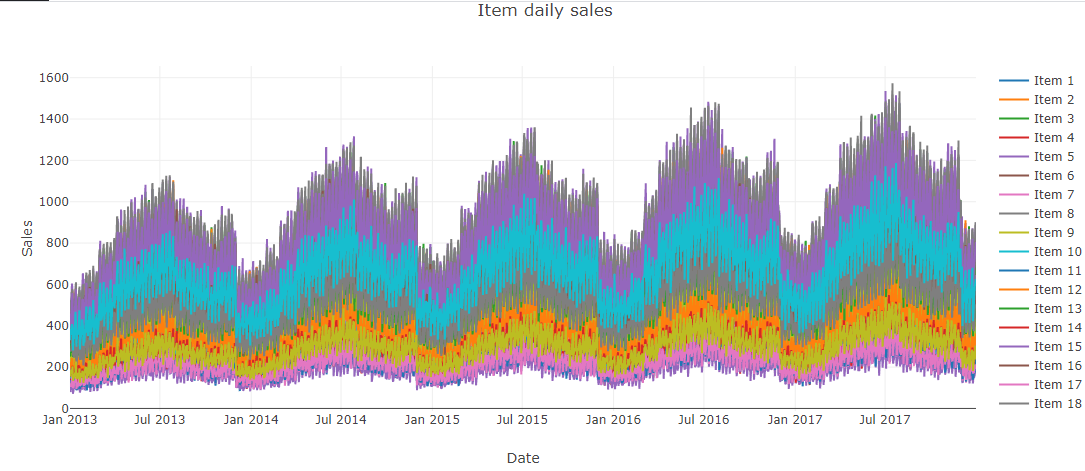

In [ ]:
lag_size = (test['date'].max().date() - train['date'].max().date()).days

In [ ]:
daily_sales = train.groupby('date', as_index=False)['sales'].sum()
store_daily_sales = train.groupby(['store', 'date'], as_index=False)['sales'].sum()
item_daily_sales = train.groupby(['item', 'date'], as_index=False)['sales'].sum()

In [ ]:
store_daily_sales_sc = []
for store in store_daily_sales['store'].unique():
    current_store_daily_sales = store_daily_sales[(store_daily_sales['store'] == store)]

In [ ]:
item_daily_sales_sc = []
for item in item_daily_sales['item'].unique():
    current_item_daily_sales = item_daily_sales[(item_daily_sales['item'] == item)]

In [ ]:
train = train[(train['date'] >= '2017-01-01')]

In [ ]:
train_gp = train.sort_values('date').groupby(['item', 'store', 'date'], as_index=False)
train_gp = train_gp.agg({'sales':['mean']})
train_gp.columns = ['item', 'store', 'date', 'sales']
train_gp.head()

,item,store,date,sales
0,1,1,2017-01-01,19.0
1,1,1,2017-01-02,15.0
2,1,1,2017-01-03,10.0
3,1,1,2017-01-04,16.0
4,1,1,2017-01-05,14.0


In [ ]:
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
window = 127
lag = lag_size
series = series_to_supervised(train_gp.drop('date', axis=1), window=window, lag=lag)
series.head()

,item(t-127),store(t-127),sales(t-127),item(t-126),store(t-126),sales(t-126),item(t-125),store(t-125),sales(t-125),item(t-124),...,sales(t-2),item(t-1),store(t-1),sales(t-1),item(t),store(t),sales(t),item(t+90),store(t+90),sales(t+90)
127,1.0,1.0,19.0,1.0,1.0,15.0,1.0,1.0,10.0,1.0,...,34.0,1.0,1.0,31.0,1,1,24.0,1.0,1.0,29.0
128,1.0,1.0,15.0,1.0,1.0,10.0,1.0,1.0,16.0,1.0,...,31.0,1.0,1.0,24.0,1,1,32.0,1.0,1.0,20.0
129,1.0,1.0,10.0,1.0,1.0,16.0,1.0,1.0,14.0,1.0,...,24.0,1.0,1.0,32.0,1,1,17.0,1.0,1.0,28.0
130,1.0,1.0,16.0,1.0,1.0,14.0,1.0,1.0,24.0,1.0,...,32.0,1.0,1.0,17.0,1,1,18.0,1.0,1.0,28.0
131,1.0,1.0,14.0,1.0,1.0,24.0,1.0,1.0,14.0,1.0,...,17.0,1.0,1.0,18.0,1,1,26.0,1.0,1.0,31.0


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
cols_to_scale = [col for col in series.columns if 'weekday' not in col and 'month' not in col]
scaled_cols = scaler.fit_transform(series[cols_to_scale])
series[cols_to_scale] = scaled_cols

In [ ]:
series.tail()

,item(t-127),store(t-127),sales(t-127),item(t-126),store(t-126),sales(t-126),item(t-125),store(t-125),sales(t-125),item(t-124),...,sales(t-2),item(t-1),store(t-1),sales(t-1),item(t),store(t),sales(t),item(t+90),store(t+90),sales(t+90)
182405,1.0,1.0,0.414847,1.0,1.0,0.375546,1.0,1.0,0.410480,1.0,...,0.336245,1.0,1.0,0.340611,1.0,1.0,0.349345,1.0,1.0,0.266376
182406,1.0,1.0,0.375546,1.0,1.0,0.410480,1.0,1.0,0.432314,1.0,...,0.340611,1.0,1.0,0.349345,1.0,1.0,0.384279,1.0,1.0,0.248908
182407,1.0,1.0,0.410480,1.0,1.0,0.432314,1.0,1.0,0.471616,1.0,...,0.349345,1.0,1.0,0.384279,1.0,1.0,0.441048,1.0,1.0,0.314410
182408,1.0,1.0,0.432314,1.0,1.0,0.471616,1.0,1.0,0.292576,1.0,...,0.384279,1.0,1.0,0.441048,1.0,1.0,0.423581,1.0,1.0,0.262009
182409,1.0,1.0,0.471616,1.0,1.0,0.292576,1.0,1.0,0.388646,1.0,...,0.441048,1.0,1.0,0.423581,1.0,1.0,0.301310,1.0,1.0,0.349345


In [ ]:
series.shape

(182283, 387)

In [ ]:
last_item = 'item(t-%d)' % window
last_store = 'store(t-%d)' % window
series = series[(series['store(t)'] == series[last_store])]
series = series[(series['item(t)'] == series[last_item])]

In [ ]:
columns_to_drop = [('%s(t+%d)' % (col, lag)) for col in ['item', 'store']]
for i in range(window, 0, -1):
    columns_to_drop += [('%s(t-%d)' % (col, i)) for col in ['item', 'store']]
series.drop(columns_to_drop, axis=1, inplace=True)
series.drop(['item(t)', 'store(t)'], axis=1, inplace=True)

In [ ]:
labels_col = 'sales(t+%d)' % lag_size
labels = series[labels_col]
series = series.drop(labels_col, axis=1)

In [ ]:
series.shape

(118910, 128)

In [ ]:
X_train, X_valid, Y_train, Y_valid = train_test_split(series, labels.values, test_size=0.4, random_state=0)
print('Train set shape', X_train.shape)
print('Validation set shape', X_valid.shape)
X_train.head()

Train set shape (71346, 128)
Validation set shape (47564, 128)


,sales(t-127),sales(t-126),sales(t-125),sales(t-124),sales(t-123),sales(t-122),sales(t-121),sales(t-120),sales(t-119),sales(t-118),...,sales(t-9),sales(t-8),sales(t-7),sales(t-6),sales(t-5),sales(t-4),sales(t-3),sales(t-2),sales(t-1),sales(t)
180636,78.0,73.0,80.0,80.0,83.0,72.0,68.0,65.0,77.0,67.0,...,50.0,45.0,52.0,64.0,76.0,55.0,49.0,47.0,60.0,61.0
179077,75.0,58.0,68.0,75.0,76.0,83.0,63.0,69.0,50.0,77.0,...,67.0,63.0,61.0,73.0,90.0,93.0,83.0,69.0,80.0,70.0
148431,15.0,14.0,17.0,21.0,19.0,23.0,13.0,28.0,22.0,21.0,...,17.0,24.0,26.0,16.0,19.0,19.0,25.0,21.0,15.0,19.0
108332,37.0,36.0,52.0,47.0,25.0,30.0,31.0,37.0,41.0,39.0,...,33.0,35.0,31.0,32.0,37.0,26.0,29.0,34.0,33.0,33.0
116657,60.0,80.0,64.0,61.0,38.0,43.0,54.0,53.0,59.0,56.0,...,56.0,54.0,67.0,94.0,77.0,40.0,60.0,52.0,57.0,73.0


In [ ]:
X_train.tail()

,sales(t-127),sales(t-126),sales(t-125),sales(t-124),sales(t-123),sales(t-122),sales(t-121),sales(t-120),sales(t-119),sales(t-118),...,sales(t-9),sales(t-8),sales(t-7),sales(t-6),sales(t-5),sales(t-4),sales(t-3),sales(t-2),sales(t-1),sales(t)
70402,86.0,73.0,54.0,81.0,68.0,81.0,60.0,99.0,95.0,61.0,...,85.0,77.0,65.0,56.0,69.0,60.0,75.0,79.0,83.0,71.0
180944,42.0,63.0,76.0,70.0,70.0,72.0,64.0,61.0,61.0,63.0,...,52.0,59.0,56.0,55.0,66.0,67.0,73.0,41.0,50.0,81.0
65473,70.0,67.0,84.0,81.0,65.0,60.0,71.0,63.0,59.0,67.0,...,102.0,118.0,138.0,135.0,129.0,95.0,112.0,98.0,129.0,118.0
66935,35.0,36.0,28.0,32.0,26.0,33.0,44.0,38.0,33.0,31.0,...,61.0,51.0,64.0,46.0,53.0,37.0,41.0,55.0,62.0,63.0
104717,72.0,78.0,70.0,71.0,54.0,61.0,59.0,63.0,63.0,69.0,...,58.0,51.0,38.0,62.0,76.0,56.0,62.0,64.0,68.0,59.0


In [ ]:
Y_train

array([ 32.,  59.,  16., ..., 134.,  60.,  73.])

In [ ]:
X_train.shape

TensorShape([71346, 128, 1])

In [ ]:
Y_train.shape

(71346,)

In [ ]:
X_train = tf.expand_dims(X_train, axis = -1)

In [ ]:
X_valid = tf.expand_dims(X_valid, axis = -1)

In [ ]:
def windowed_dataseto(series, window_size, batch_size):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [ ]:
# Parameters
window_size = 30
batch_size = 128

# Generate the dataset windows
train_set = windowed_dataseto(X_train, window_size, batch_size)

NameError: ignored

In [ ]:
train_set

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 128, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 128, 1), dtype=tf.float64, name=None))>

In [ ]:
X_trains, X_valids, Y_trains, Y_valids = train_test_split(series, labels.values, test_size=0.4, random_state=0)
print('Train set shape', X_trains.shape)
print('Validation set shape', X_valids.shape)

Train set shape (71346, 128)
Validation set shape (47564, 128)


# Features 30 windows

In [ ]:
window = 29
lag = lag_size
series3 = series_to_supervised(train_gp.drop('date', axis=1), window=window, lag=lag)
series3.head()

,item(t-29),store(t-29),sales(t-29),item(t-28),store(t-28),sales(t-28),item(t-27),store(t-27),sales(t-27),item(t-26),...,sales(t-2),item(t-1),store(t-1),sales(t-1),item(t),store(t),sales(t),item(t+90),store(t+90),sales(t+90)
29,1.0,1.0,19.0,1.0,1.0,15.0,1.0,1.0,10.0,1.0,...,16.0,1.0,1.0,24.0,1,1,9.0,1.0,1.0,33.0
30,1.0,1.0,15.0,1.0,1.0,10.0,1.0,1.0,16.0,1.0,...,24.0,1.0,1.0,9.0,1,1,17.0,1.0,1.0,15.0
31,1.0,1.0,10.0,1.0,1.0,16.0,1.0,1.0,14.0,1.0,...,9.0,1.0,1.0,17.0,1,1,15.0,1.0,1.0,21.0
32,1.0,1.0,16.0,1.0,1.0,14.0,1.0,1.0,24.0,1.0,...,17.0,1.0,1.0,15.0,1,1,17.0,1.0,1.0,29.0
33,1.0,1.0,14.0,1.0,1.0,24.0,1.0,1.0,14.0,1.0,...,15.0,1.0,1.0,17.0,1,1,24.0,1.0,1.0,19.0


In [ ]:
last_item = 'item(t-%d)' % window
last_store = 'store(t-%d)' % window
series3 = series3[(series3['store(t)'] == series3[last_store])]
series3 = series3[(series3['item(t)'] == series3[last_item])]

In [ ]:
columns_to_drop = [('%s(t+%d)' % (col, lag)) for col in ['item', 'store']]
for i in range(window, 0, -1):
    columns_to_drop += [('%s(t-%d)' % (col, i)) for col in ['item', 'store']]
series3.drop(columns_to_drop, axis=1, inplace=True)
series3.drop(['item(t)', 'store(t)'], axis=1, inplace=True)

In [ ]:
labels_col = 'sales(t+%d)' % lag_size
labels = series3[labels_col]
series3 = series3.drop(labels_col, axis=1)

In [ ]:
'''
X_train, X_valid, Y_train, Y_valid = train_test_split(series3, labels.values, test_size=0.4, random_state=0)
print('Train set shape', X_train.shape)
print('Validation set shape', X_valid.shape)
X_train.head()
'''

"\nX_train, X_valid, Y_train, Y_valid = train_test_split(series3, labels.values, test_size=0.4, random_state=0)\nprint('Train set shape', X_train.shape)\nprint('Validation set shape', X_valid.shape)\nX_train.head()\n"

# 3. Masking

**Look-Ahead Mask**

In training, you will have access to the complete correct output of your training example. The look-ahead mask helps your model pretend that it correctly predicted a part of the output and see if, without looking ahead, it can correctly predict the next output.

For example, if the expected correct output is [1, 2, 3] and you wanted to see if given that the model correctly predicted the first value it could predict the second value, you would mask out the second and third values. So you would input the masked sequence [1, -1e9, -1e9] and see if it could generate [1, 2, -1e9].

In [ ]:
def create_look_ahead_mask(size):
    """
    Returns an upper triangular matrix filled with ones
    
    Arguments:
        size -- matrix size
    
    Returns:
        mask -- (size, size) tensor
    """
    mask = tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask 

# SpecNorm

In [ ]:
from tensorflow.python.eager import def_function
from tensorflow.python.framework import dtypes
from tensorflow.python.framework import tensor_shape
from tensorflow.python.keras import backend as K
from tensorflow.python.keras import layers
from tensorflow.python.keras import initializers
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops
# import tensorflow as tf
class SpectralNormalization(tf.keras.layers.Wrapper):
    """
    Attributes:
       layer: tensorflow keras layers (with kernel attribute)
    """

    def __init__(self, layer, **kwargs):
        super(SpectralNormalization, self).__init__(layer, **kwargs)

    def build(self, input_shape):
        """Build `Layer`"""

        if not self.layer.built:
            self.layer.build(input_shape)

        if not hasattr(self.layer, 'kernel'):
            raise ValueError(
                '`SpectralNormalization` must wrap a layer that'
                ' contains a `kernel` for weights')
        if hasattr(self.layer, 'recurrent_kernel'):
            print("YAYYYYYYYYY")

        self.w = self.layer.kernel
        self.w_shape = self.w.shape.as_list()
        self.u = self.add_weight(
            shape=tuple([1, self.w_shape[-1]]),
            initializer=initializers.TruncatedNormal(stddev=0.02),
            name='sn_u',
            trainable=False,
            dtype=dtypes.float32)

        super(SpectralNormalization, self).build()

    @def_function.function
    def call(self, inputs, training=None):
        """Call `Layer`"""
        if training is None:
            training = K.learning_phase()
        
        if training==True:
            # Recompute weights for each forward pass
            self._compute_weights()
        
        output = self.layer(inputs)
        return output

    def _compute_weights(self):
        """Generate normalized weights.
        This method will update the value of self.layer.kernel with the
        normalized value, so that the layer is ready for call().
        """
        w_reshaped = array_ops.reshape(self.w, [-1, self.w_shape[-1]])
        eps = 1e-12
        _u = array_ops.identity(self.u)
        _v = math_ops.matmul(_u, array_ops.transpose(w_reshaped))
        _v = _v / math_ops.maximum(math_ops.reduce_sum(_v**2)**0.5, eps)
        _u = math_ops.matmul(_v, w_reshaped)
        _u = _u / math_ops.maximum(math_ops.reduce_sum(_u**2)**0.5, eps)

        self.u.assign(_u)
        sigma = math_ops.matmul(math_ops.matmul(_v, w_reshaped), array_ops.transpose(_u))

        self.layer.kernel.assign(self.w / sigma)

    def compute_output_shape(self, input_shape):
        return tensor_shape.TensorShape(
            self.layer.compute_output_shape(input_shape).as_list())

class SpectralNormalization_RNN(tf.keras.layers.Wrapper):
    """
    Attributes:
       layer: tensorflow keras layers (with kernel attribute)
    """

    def __init__(self, layer, **kwargs):
        super(SpectralNormalization_RNN, self).__init__(layer, **kwargs)

    def build(self, input_shape):
        """Build `Layer`"""

        if not self.layer.built:
            self.layer.build(input_shape)

        if not hasattr(self.layer, 'kernel'):
            raise ValueError(
                '`SpectralNormalization` must wrap a layer that'
                ' contains a `kernel` for weights')
            
        self.w = self.layer.kernel
        self.w2 = self.layer.recurrent_kernel

        self.w_shape = self.w.shape.as_list()
        self.w2_shape = self.w2.shape.as_list()

        self.u = self.add_weight(
            shape=tuple([1, self.w_shape[-1]]),
            initializer=initializers.TruncatedNormal(stddev=0.02),
            name='sn_u',
            trainable=False,
            dtype=dtypes.float32)
        self.u2 = self.add_weight(
            shape=tuple([1, self.w2_shape[-1]]),
            initializer=initializers.TruncatedNormal(stddev=0.02),
            name='sn_u2',
            trainable=False,
            dtype=dtypes.float32)

        super(SpectralNormalization_RNN, self).build()

    @def_function.function
    def call(self, inputs, training=None):
        """Call `Layer`"""
        if training is None:
            training = K.learning_phase()
        
        if training==True:
            # Recompute weights for each forward pass
            self._compute_weights()
        
        output = self.layer(inputs)
        return output

    def _compute_weights(self,it=5):
        """Generate normalized weights.
        This method will update the value of self.layer.kernel with the
        normalized value, so that the layer is ready for call().
        """
        # w = tf.reshape(self.w, [-1, self.w_shape[-1]])
        # u = self.u

        # for _ in range(it):
        #     v = tf.math.l2_normalize(tf.matmul(u, w, transpose_b=True))
        #     u = tf.math.l2_normalize(tf.matmul(v, w))

        # sigma = tf.matmul(tf.matmul(v, w), u, transpose_b=True)

        # self.layer.kernel.assign(self.w / sigma)
        # self.u.assign(u)

        # w = tf.reshape(self.w2, [-1, self.w2_shape[-1]])
        # u = self.u2

        # for _ in range(it):
        #     v = tf.math.l2_normalize(tf.matmul(u, w, transpose_b=True))
        #     u = tf.math.l2_normalize(tf.matmul(v, w))

        # sigma = tf.matmul(tf.matmul(v, w), u, transpose_b=True)

        # self.layer.recurrent_kernel.assign(self.w2 / sigma)
        # self.u2.assign(u)


        w_reshaped = array_ops.reshape(self.w, [-1, self.w_shape[-1]])
        eps = 1e-12
        _u = self.u
        for i in range(it):
            _u = array_ops.identity(_u)
            _v = math_ops.matmul(_u, array_ops.transpose(w_reshaped))
            _v = _v / math_ops.maximum(math_ops.reduce_sum(_v**2)**0.5, eps)
            _u = math_ops.matmul(_v, w_reshaped)
            _u = _u / math_ops.maximum(math_ops.reduce_sum(_u**2)**0.5, eps)
        
        self.u.assign(_u)
        sigma = math_ops.matmul(math_ops.matmul(_v, w_reshaped), array_ops.transpose(_u))

        

        w2_reshaped = array_ops.reshape(self.w2, [-1, self.w2_shape[-1]])
        eps = 1e-12
        _u2 = self.u2
        for i in range(it):
            _u2 = array_ops.identity(_u2)
            _v2 = math_ops.matmul(_u2, array_ops.transpose(w2_reshaped))
            _v2 = _v2 / math_ops.maximum(math_ops.reduce_sum(_v2**2)**0.5, eps)
            _u2 = math_ops.matmul(_v2, w2_reshaped)
            _u2 = _u2 / math_ops.maximum(math_ops.reduce_sum(_u2**2)**0.5, eps)

        self.u2.assign(_u2)
        sigma = math_ops.matmul(math_ops.matmul(_v2, w2_reshaped), array_ops.transpose(_u2))

        

    def compute_output_shape(self, input_shape):
        return tensor_shape.TensorShape(
            self.layer.compute_output_shape(input_shape).as_list())

# 4. Model Sendiri

  "The use of self-attention paired with traditional convolutional networks allows for the parallization which speeds up training. You will implement **scaled dot product attention** which takes in a query, key, value, and a mask as inputs to returns rich, attention-based vector representations of the words in your sequence. This type of self-attention can be mathematically expressed as:

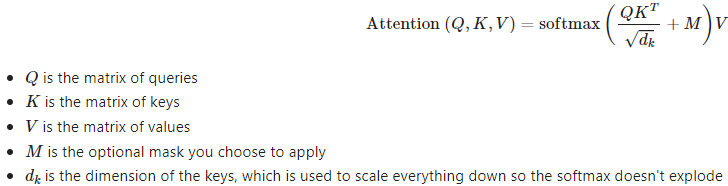

In [ ]:
def scaled_dot_product_attention(q, k, v, mask):
    """
    Calculate the attention weights.
      q, k, v must have matching leading dimensions.
      k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
      The mask has different shapes depending on its type(padding or look ahead) 
      but it must be broadcastable for addition.

    Arguments:
        q -- query shape == (..., seq_len_q, depth)
        k -- key shape == (..., seq_len_k, depth)
        v -- value shape == (..., seq_len_v, depth_v)
        mask: Float tensor with shape broadcastable 
              to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
        output -- attention_weights
    """
    
    # Q*K'
    matmul_qk = tf.matmul(q, k, transpose_b=True)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)
    # attention_weights * V
    output = tf.matmul(attention_weights, v)   # (..., seq_len_q, depth_v)

    return output, attention_weights

Feed forward neural network contains two Dense layers which we'll implement as the function FullyConnected
Your input sentence first passes through a multi-head attention layer, where the encoder looks at other words in the input sentence as it encodes a specific word. The outputs of the multi-head attention layer are then fed to a feed forward neural network. The exact same feed forward network is independently applied to each position.

In [ ]:
def FullyConnected(embedding_dim, fully_connected_dim):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(fully_connected_dim, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(embedding_dim)  # (batch_size, seq_len, d_model)
    ])

## Encoder Layer

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    """
    The encoder layer is composed by a multi-head self-attention mechanism,
    followed by a simple, positionwise fully connected feed-forward network. 
    This archirecture includes a residual connection around each of the two 
    sub-layers, followed by layer normalization.
    """
    def __init__(self, embedding_dim, num_heads, fully_connected_dim, dropout_rate=0.1, layernorm_eps=1e-6, spec_norm=False):
        super(EncoderLayer, self).__init__()
        self.spec_norm = spec_norm
        self.mha = tf.keras.layers.MultiHeadAttention(num_heads=num_heads,
                                      key_dim=embedding_dim)

        self.ffn = FullyConnected(embedding_dim=embedding_dim,
                                  fully_connected_dim=fully_connected_dim)
        
        self.ff_conv1D_1 = tf.keras.layers.Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')
        self.ff_conv1D_2 = tf.keras.layers.Conv1D(filters=7, kernel_size=1) # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1]=7 

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=layernorm_eps)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=layernorm_eps)

        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)
    
    def call(self, x, training, mask):
        """
        Forward pass for the Encoder Layer
        
        Arguments:
            x -- Tensor of shape (batch_size, input_seq_len, embedding_dim)
            training -- Boolean, set to true to activate
                        the training mode for dropout layers
            mask -- Boolean mask to ensure that the padding is not 
                    treated as part of the input
        Returns:
            out2 -- Tensor of shape (batch_size, input_seq_len, embedding_dim)
        """
        # calculate self-attention using mha(~1 line)
        #-> To compute self-attention Q, V and K should be the same (x)
        self_attn_output = self.mha(x, x, x, mask) # Self attention (batch_size, input_seq_len, embedding_dim)
        
        # apply dropout layer to the self-attention output (~1 line)
        self_attn_output = self.dropout1(self_attn_output, training=training)
        
        # apply layer normalization on sum of the input and the attention output to get the  
        # output of the multi-head attention layer (~1 line)
        mult_attn_out = self.layernorm1(x + self_attn_output)  # (batch_size, input_seq_len, embedding_dim)

        # pass the output of the multi-head attention layer through a ffn (~1 line)
        ffn_output = self.ffn(mult_attn_out)  # (batch_size, input_seq_len, embedding_dim)
        
        # apply dropout layer to ffn output (~1 line)
        ffn_output = self.dropout2(ffn_output, training=training)
        
        # apply layer normalization on sum of the output from multi-head attention and ffn output to get the
        # output of the encoder layer (~1 line)
        encoder_layer_out = self.layernorm2(ffn_output + mult_attn_out)  # (batch_size, input_seq_len, embedding_dim)
        
        return encoder_layer_out

In [ ]:
class Encoder(tf.keras.layers.Layer):
    """
    The entire Encoder starts by passing the input to an embedding layer 
    and using positional encoding to then pass the output through a stack of
    encoder Layers
        
    """   
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, dropout_rate=0.1, layernorm_eps=1e-6, spec_norm=False): #(self, num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size, maximum_position_encoding, dropout_rate=0.1, layernorm_eps=1e-6, spec_norm=False)
        super(Encoder, self).__init__()

        if spec_norm:
          self.spec_norm = SpectralNormalization
        else:
          self.spec_norm = lambda x:x

        self.embedding_dim = embedding_dim
        self.num_layers = num_layers

        self.time_embedding = Time2Vector(embedding_dim)

        #self.embedding = TimeDistributed(self.spec_norm(tf.keras.layers.Dense(d_model,kernel_initializer = tf.keras.initializers.Orthogonal())))

        """self.enc_layers = [EncoderLayer(embedding_dim=self.embedding_dim,
                                        num_heads=num_heads,
                                        fully_connected_dim=fully_connected_dim,
                                        dropout_rate=dropout_rate,
                                        layernorm_eps=layernorm_eps, spec_norm) 
                           for _ in range(self.num_layers)]"""

        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        
    def call(self, x, training, mask):
        """
        Forward pass for the Encoder
        
        Arguments:
            x -- Tensor of shape (batch_size, input_seq_len)
            training -- Boolean, set to true to activate
                        the training mode for dropout layers
            mask -- Boolean mask to ensure that the padding is not 
                    treated as part of the input
        Returns:
            out2 -- Tensor of shape (batch_size, input_seq_len, embedding_dim)
        """

        seq_len = tf.shape(x)[1]
        
        # START CODE HERE
        # Pass input through the Embedding layer
        #x = self.embedding(x)  # (batch_size, input_seq_len, embedding_dim)
        # Scale embedding by multiplying it by the square root of the embedding dimension
        #x *= tf.math.sqrt(tf.cast(self.embedding_dim,tf.float32))
        # Add the position encoding to embedding
        #x += self.pos_encoding[:, :seq_len, :]
        x = self.time_embedding(x)
        # Pass the encoded embedding through a dropout layer
        x = self.dropout(x, training=training)
        # Pass the output through the stack of encoding layers 
        for i in range(self.num_layers):
            x = self.enc_layers[i](x,training, mask)
        # END CODE HERE

        return x  # (batch_size, input_seq_len, embedding_dim)

## DecoderLayer

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
    """
    The decoder layer is composed by two multi-head attention blocks, 
    one that takes the new input and uses self-attention, and the other 
    one that combines it with the output of the encoder, followed by a
    fully connected block. 
    """
    def __init__(self, embedding_dim, num_heads, fully_connected_dim, dropout_rate=0.1, layernorm_eps=1e-6):
        super(DecoderLayer, self).__init__()

        self.mha1 = tf.keras.layers.MultiHeadAttention(num_heads=num_heads,
                                      key_dim=embedding_dim)

        self.mha2 = tf.keras.layers.MultiHeadAttention(num_heads=num_heads,
                                      key_dim=embedding_dim)

        self.ffn = FullyConnected(embedding_dim=embedding_dim,
                                  fully_connected_dim=fully_connected_dim)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=layernorm_eps)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=layernorm_eps)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=layernorm_eps)

        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)
        self.dropout3 = tf.keras.layers.Dropout(dropout_rate)
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        """
        Forward pass for the Decoder Layer
        
        Arguments:
            x -- Tensor of shape (batch_size, target_seq_len, embedding_dim)
            enc_output --  Tensor of shape(batch_size, input_seq_len, embedding_dim)
            training -- Boolean, set to true to activate
                        the training mode for dropout layers
            look_ahead_mask -- Boolean mask for the target_input
            padding_mask -- Boolean mask for the second multihead attention layer
        Returns:
            out3 -- Tensor of shape (batch_size, target_seq_len, embedding_dim)
            attn_weights_block1 -- Tensor of shape(batch_size, num_heads, target_seq_len, input_seq_len)
            attn_weights_block2 -- Tensor of shape(batch_size, num_heads, target_seq_len, input_seq_len)
        """
        # enc_output.shape == (batch_size, input_seq_len, embedding_dim)
        
        # BLOCK 1
        # calculate self-attention and return attention scores as attn_weights_block1 (~1 line)
        attn1, attn_weights_block1 = self.mha1(x, x, x,look_ahead_mask, return_attention_scores=True)  # (batch_size, target_seq_len, d_model)
        
        # apply dropout layer on the attention output (~1 line)
        attn1 = self.dropout1(attn1, training = training)
        
        # apply layer normalization to the sum of the attention output and the input (~1 line)
        out1 = self.layernorm1(attn1 + x)

        # BLOCK 2
        # calculate self-attention using the Q from the first block and K and V from the encoder output.
        # MultiHeadAttention's call takes input (Query, Value, Key, attention_mask, return_attention_scores, training)
        # Return attention scores as attn_weights_block2 (~1 line)
        attn2, attn_weights_block2 = self.mha2( out1,enc_output, enc_output, padding_mask, return_attention_scores=True)  # (batch_size, target_seq_len, d_model)
        
        # apply dropout layer on the attention output (~1 line)
        attn2 = self.dropout2(attn2, training=training)
        
        # apply layer normalization to the sum of the attention output and the output of the first block (~1 line)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, embedding_dim)
        
        #BLOCK 3
        # pass the output of the second block through a ffn
        ffn_output = self.ffn(out2) # (batch_size, target_seq_len, embedding_dim)
        
        # apply a dropout layer to the ffn output
        ffn_output = self.dropout3(ffn_output, training=training)
        
        # apply layer normalization to the sum of the ffn output and the output of the second block
        out3 =  self.layernorm3(ffn_output + out2) # (batch_size, target_seq_len, embedding_dim)

        return out3, attn_weights_block1, attn_weights_block2

In [ ]:
class Decoder(tf.keras.layers.Layer):
    """
    The entire Encoder is starts by passing the target input to an embedding layer 
    and using positional encoding to then pass the output through a stack of
    decoder Layers
        
    """ 
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, dropout_rate=0.1, layernorm_eps=1e-6):
      #(self, num_layers, embedding_dim, num_heads, fully_connected_dim, target_vocab_size, maximum_position_encoding, dropout_rate=0.1, layernorm_eps=1e-6)
        super(Decoder, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_layers = num_layers

        #self.embedding = TimeDistributed(tf.keras.layers.Dense(d_model,kernel_initializer = tf.keras.initializers.Orthogonal()))
        self.time_embedding = Time2Vector(embedding_dim)

        self.dec_layers = [DecoderLayer(embedding_dim=self.embedding_dim,
                                        num_heads=num_heads,
                                        fully_connected_dim=fully_connected_dim,
                                        dropout_rate=dropout_rate,
                                        layernorm_eps=layernorm_eps) 
                           for _ in range(self.num_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
    
    def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
        """
        Forward  pass for the Decoder
        
        Arguments:
            x -- Tensor of shape (batch_size, target_seq_len, embedding_dim)
            enc_output --  Tensor of shape(batch_size, input_seq_len, embedding_dim)
            training -- Boolean, set to true to activate
                        the training mode for dropout layers
            look_ahead_mask -- Boolean mask for the target_input
            padding_mask -- Boolean mask for the second multihead attention layer
        Returns:
            x -- Tensor of shape (batch_size, target_seq_len, embedding_dim)
            attention_weights - Dictionary of tensors containing all the attention weights
                                each of shape Tensor of shape (batch_size, num_heads, target_seq_len, input_seq_len)
        """

        seq_len = tf.shape(x)[1]
        attention_weights = {}
        
        # create word embeddings 
        #x = self.embedding(x)  # (batch_size, target_seq_len, embedding_dim)
        
        # scale embeddings by multiplying by the square root of their dimension
        #x *= tf.math.sqrt(tf.cast(self.embedding_dim, tf.float32))
        
        # calculate positional encodings and add to word embedding
        #x += self.pos_encoding[:, :seq_len, :]

        x = self.time_embedding(x)
        
        # apply a dropout layer to x
        x = self.dropout(x, training=training)

        # use a for loop to pass x through a stack of decoder layers and update attention_weights (~4 lines total)
        for i in range(self.num_layers):
            # pass x and the encoder output through a stack of decoder layers and save the attention weights
            # of block 1 and 2 (~1 line)
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)

            #update attention_weights dictionary with the attention weights of block 1 and block 2
            attention_weights['decoder_layer{}_block1_self_att'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2_decenc_att'.format(i+1)] = block2
        # END CODE HERE
        
        # x.shape == (batch_size, target_seq_len, embedding_dim)
        return x, attention_weights

## Model

In [ ]:
class Transformer(tf.keras.Model):
    """
    Complete transformer with an Encoder and a Decoder
    """
    def __init__(self, n_target_features, num_layers, embedding_dim, num_heads, fully_connected_dim, dropout_rate=0.1, layernorm_eps=1e-6):
      #(self, num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size, 
               #target_vocab_size, max_positional_encoding_input,
               #max_positional_encoding_target, dropout_rate=0.1, layernorm_eps=1e-6)
        super(Transformer, self).__init__()

        self.n_target_features = n_target_features

        self.encoder = Encoder(num_layers=num_layers,
                               embedding_dim=embedding_dim,
                               num_heads=num_heads,
                               fully_connected_dim=fully_connected_dim,
                               dropout_rate=dropout_rate,
                               layernorm_eps=layernorm_eps)
        '''(num_layers=num_layers,
                               embedding_dim=embedding_dim,
                               num_heads=num_heads,
                               fully_connected_dim=fully_connected_dim,
                               input_vocab_size=input_vocab_size,
                               maximum_position_encoding=max_positional_encoding_input,
                               dropout_rate=dropout_rate,
                               layernorm_eps=layernorm_eps)'''

        self.decoder = Decoder(num_layers=num_layers, 
                               embedding_dim=embedding_dim,
                               num_heads=num_heads,
                               fully_connected_dim=fully_connected_dim,
                               dropout_rate=dropout_rate,
                               layernorm_eps=layernorm_eps)
        '''
        (num_layers=num_layers, 
                               embedding_dim=embedding_dim,
                               num_heads=num_heads,
                               fully_connected_dim=fully_connected_dim,
                               target_vocab_size=target_vocab_size, 
                               maximum_position_encoding=max_positional_encoding_target,
                               dropout_rate=dropout_rate,
                               layernorm_eps=layernorm_eps)
        '''

        self.final_layer = tf.keras.layers.Dense(1, activation='linear')
        #self.final_layer = tf.keras.layers.Dense(self.n_target_features, activation='linear')
    
    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        """
        Forward pass for the entire Transformer
        Arguments:
            inp -- Tensor of shape (batch_size, input_seq_len, fully_connected_dim)
            tar -- Tensor of shape (batch_size, target_seq_len, fully_connected_dim)
            training -- Boolean, set to true to activate
                        the training mode for dropout layers
            enc_padding_mask -- Boolean mask to ensure that the padding is not 
                    treated as part of the input
            look_ahead_mask -- Boolean mask for the target_input
            padding_mask -- Boolean mask for the second multihead attention layer
        Returns:
            final_output -- Describe me
            attention_weights - Dictionary of tensors containing all the attention weights for the decoder
                                each of shape Tensor of shape (batch_size, num_heads, target_seq_len, input_seq_len)
        
        """
        # call self.encoder with the appropriate arguments to get the encoder output
        look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
        
        enc_output = self.encoder(inp,training,enc_padding_mask) # (batch_size, inp_seq_len, fully_connected_dim)
        
        # call self.decoder with the appropriate arguments to get the decoder output
        # dec_output.shape == (batch_size, tar_seq_len, fully_connected_dim)
        dec_output = self.decoder(tar, enc_output, training, look_ahead_mask, None) #(tar, enc_output, training, look_ahead_mask, dec_padding_mask)
        
        # pass decoder output through a linear layer and softmax (~2 lines)
        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
        # START CODE HERE

        return final_output

In [ ]:
num_layers = 6
embedding_dim = 4
num_heads = 4
fully_connected_dim = 8
input_vocab_size = 30
target_vocab_size = 35
max_positional_encoding_input = 5
max_positional_encoding_target = 6

In [ ]:
xformer = Transformer(3, num_layers=4, num_heads=4, fully_connected_dim = 256, embedding_dim = 32)

In [ ]:
xformer.summary()

ValueError: ignored

In [ ]:
tf.random.normal(3,24,4)

In [ ]:
pred = xformer(tf.random.normal((1,24,4)),tf.random.normal((1,6,3)),False)
# xformer.load_weights("xformer.h5")
print(pred.shape)
xformer.summary()

# 5. Model

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Attention

In [ ]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

@tf.function
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)


def create_masks(inp, tar):
  # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)

  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

@tf.function  
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead)
    but it must be broadcastable for addition.

    Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable
          to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
    output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    # dk = k.get_shape().as_list()[-1]
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads,spec_norm=False):
        super(MultiHeadAttention, self).__init__()
        self.kernel_init = tf.keras.initializers.Orthogonal()
        self.num_heads = num_heads
        self.d_model = d_model
        if spec_norm:
            self.spec_norm = SpectralNormalization
        else:
            self.spec_norm = lambda x: x

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = self.spec_norm(tf.keras.layers.Dense(d_model,kernel_initializer=self.kernel_init))
        self.wk = self.spec_norm(tf.keras.layers.Dense(d_model,kernel_initializer=self.kernel_init))
        self.wv = self.spec_norm(tf.keras.layers.Dense(d_model,kernel_initializer=self.kernel_init))

        self.dense = self.spec_norm(tf.keras.layers.Dense(d_model,kernel_initializer=self.kernel_init))
        # self.attn_layer = Attention(use_scale=True)
        
    @tf.function   
    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention= scaled_dot_product_attention(q, k, v, mask)
        # scaled_attention = self.attn_layer([q,v,k],[mask,None])
        # attention_weights = None

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output
    
def point_wise_feed_forward_network(d_model, dff,spec_norm=False):
    if spec_norm:
        wrapper = SpectralNormalization
    else:
        wrapper = lambda x: x
    kernel_init = tf.keras.initializers.Orthogonal()
    return tf.keras.Sequential([
      wrapper(tf.keras.layers.Dense(dff, activation='relu',kernel_initializer=kernel_init)),  # (batch_size, seq_len, dff)
      wrapper(tf.keras.layers.Dense(d_model,kernel_initializer=kernel_init))  # (batch_size, seq_len, d_model)
    ])

class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1,spec_norm=False):
        super(EncoderLayer, self).__init__()
        self.spec_norm = spec_norm
        self.mha = MultiHeadAttention(d_model, num_heads,self.spec_norm)
        self.ffn = point_wise_feed_forward_network(d_model, dff,self.spec_norm)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
         
    def call(self, x, training, mask):

        attn_output = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2
    
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
        
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)

        attn1= self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2 = self.mha2(enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3
    
from tensorflow.keras.layers import TimeDistributed
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, rate=0.1,spec_norm=False):
        super(Encoder, self).__init__()
        
        if spec_norm:
            self.spec_norm = SpectralNormalization
        else:
            self.spec_norm = lambda x: x


        self.d_model = d_model
        self.num_layers = num_layers
        
        self.embedding = TimeDistributed(self.spec_norm(tf.keras.layers.Dense(d_model,kernel_initializer = tf.keras.initializers.Orthogonal())))
        
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate,spec_norm) for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)
        
    def build(self, input_shape):
        self.n_timesteps = input_shape.as_list()[1]
        self.pos_encoding = positional_encoding(self.n_timesteps, self.d_model)
           
    def transform(self,x):
        seq_len = x.get_shape().as_list()[1]

        # adding embedding and position encoding.
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        # x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x * np.sqrt(self.d_model)
        x = x + self.pos_encoding[:, :seq_len, :]
        return x

    def call(self, x, training, mask):

        # seq_len = tf.shape(x)[1]

        # adding embedding and position encoding.
        # x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        # x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        # x = x * np.sqrt(self.d_model)
        # x = x + self.pos_encoding[:, :seq_len, :]
        x = self.transform(x)
        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x  # (batch_size, input_seq_len, d_model)
    
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = TimeDistributed(tf.keras.layers.Dense(d_model,kernel_initializer = tf.keras.initializers.Orthogonal()))

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
        
    def build(self, input_shape):
        self.n_timesteps = input_shape.as_list()[1]
        self.pos_encoding = positional_encoding(self.n_timesteps, self.d_model)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):

        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.dec_layers[i](x, enc_output, training,
                                                 look_ahead_mask, padding_mask)

            # attention_weights[f'decoder_layer{i+1}_block1'] = block1
            # attention_weights[f'decoder_layer{i+1}_block2'] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x
    
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    # return tf.cast(pos_encoding, dtype=tf.float32)
    return pos_encoding

class Transformer(tf.keras.Model):
    def __init__(self,n_target_features, num_layers=4, d_model=128, num_heads=8, dff=512, rate=0.1):
        super(Transformer, self).__init__()
        
        self.n_target_features = n_target_features
        self.tokenizer = Encoder(num_layers, d_model, num_heads, dff, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, rate)

        # self.final_layer = TimeDistributed(tf.keras.layers.Dense(self.n_target_features))
        self.final_layer = tf.keras.layers.Dense(self.n_target_features)

    def call(self, inp, tar, training):

        look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
        
        enc_output = self.tokenizer(inp, training, None)  # (batch_size, inp_seq_len, d_model)

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output = self.decoder(tar, enc_output, training, look_ahead_mask, None)

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output

In [ ]:
xformer = Transformer(1,num_layers=4,num_heads=4,dff=256,d_model=32)
pred = xformer(tf.random.normal((3,24,1)),tf.random.normal((3,7,1)),False)
# xformer.load_weights("xformer.h5")
print(pred.shape)
xformer.summary()

In [ ]:
xformer.compile(loss='mse', optimizer=adam, metrics=['mae', 'mape'])

In [ ]:
history = xformer.fit(X_train_series, Y_train, 
                      batch_size=batch_size, 
                      epochs=35,
                      validation_data=(X_valid_series, Y_valid))

In [ ]:
pred

In [ ]:
d_model = 32
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
    
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,epsilon=1e-9)
optimizer2 = tf.keras.optimizers.Adam(beta_1=0.9, beta_2=0.98,epsilon=1e-9)

In [ ]:
len_data = sum(1 for _ in input_dataset)

In [ ]:
for e in range(200):
    for i,batch in enumerate(zip(input_dataset, target_dataset)):

        if i<len_data-1:
            in1, tar = batch
            
            tar_inp = tf.ones((256,1,1))*-0.1
            tar_inp = tf.concat([tar_inp,tar[:, :-1]],axis=1)
            tar_real = tar[:, 1:]

            with tf.GradientTape() as tape:
                predictions = xformer(in1, tar_inp,True)
                loss = tf.reduce_mean(tf.square(tar_real-predictions[:,:-1]))
            gradients = tape.gradient(loss, xformer.trainable_variables)
            optimizer.apply_gradients(zip(gradients, xformer.trainable_variables))
    print(f"epoch {e}| Transformer:{loss.numpy()}")

In [ ]:
train_eval = xformer.evaluate(input_dataset, target_dataset, verbose=0)

# Trans+Timeem

In [ ]:
batch_size = 32
seq_len = 128

d_k = 256
d_v = 256
n_heads = 12
ff_dim = 256

lr = 1e-5
adam = tf.keras.optimizers.Adam(lr)

In [ ]:
import numpy as np
import pandas as pd
import os, datetime
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
print('Tensorflow version: {}'.format(tf.__version__))

import matplotlib.pyplot as plt
plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

Tensorflow version: 2.9.2


In [ ]:
class SingleAttention(Layer):
  def __init__(self, d_k, d_v):
    super(SingleAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v

  def build(self, input_shape):
    self.query = Dense(self.d_k, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')
    
    self.key = Dense(self.d_k, 
                     input_shape=input_shape, 
                     kernel_initializer='glorot_uniform', 
                     bias_initializer='glorot_uniform')
    
    self.value = Dense(self.d_v, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')

  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    q = self.query(inputs[0])
    k = self.key(inputs[1])

    attn_weights = tf.matmul(q, k, transpose_b=True)
    attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights)
    attn_weights = tf.nn.softmax(attn_weights, axis=-1)
    
    v = self.value(inputs[2])
    attn_out = tf.matmul(attn_weights, v)
    return attn_out    

#############################################################################

class MultiAttention(Layer):
  def __init__(self, d_k, d_v, n_heads):
    super(MultiAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.attn_heads = list()

  def build(self, input_shape):
    for n in range(self.n_heads):
      self.attn_heads.append(SingleAttention(self.d_k, self.d_v))  
    
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1]=7 
    self.linear = Dense(input_shape[0][-1], 
                        input_shape=input_shape, 
                        kernel_initializer='glorot_uniform', 
                        bias_initializer='glorot_uniform')

  def call(self, inputs):
    attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
    concat_attn = tf.concat(attn, axis=-1)
    multi_linear = self.linear(concat_attn)
    return multi_linear   

#############################################################################

class TransformerEncoder(Layer):
  def __init__(self, d_k, d_v, n_heads, ff_dim, dropout=0.1, **kwargs):
    super(TransformerEncoder, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.ff_dim = ff_dim
    self.attn_heads = list()
    self.dropout_rate = dropout

  def build(self, input_shape):
    self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads)
    self.attn_dropout = Dropout(self.dropout_rate)
    self.attn_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

    self.ff_conv1D_1 = Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1] = 7 
    self.ff_conv1D_2 = Conv1D(filters=input_shape[0][-1], kernel_size=1) 
    self.ff_dropout = Dropout(self.dropout_rate)
    self.ff_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)    
  
  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    attn_layer = self.attn_multi(inputs)
    attn_layer = self.attn_dropout(attn_layer)
    attn_layer = self.attn_normalize(inputs[0] + attn_layer)

    ff_layer = self.ff_conv1D_1(attn_layer)
    ff_layer = self.ff_conv1D_2(ff_layer)
    ff_layer = self.ff_dropout(ff_layer)
    ff_layer = self.ff_normalize(inputs[0] + ff_layer)
    return ff_layer 

  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'d_k': self.d_k,
                   'd_v': self.d_v,
                   'n_heads': self.n_heads,
                   'ff_dim': self.ff_dim,
                   'attn_heads': self.attn_heads,
                   'dropout_rate': self.dropout_rate})
    return config

In [ ]:
X_train_series.shape

(71346, 128, 1)

In [ ]:
def create_model():
  '''Initialize time and transformer layers'''
  time_embedding = Time2Vector(seq_len)
  attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

  '''Construct model'''
  in_seq = Input(shape=((X_train_series.shape[1], X_train_series.shape[2])))
  x = time_embedding(in_seq)
  x = Concatenate(axis=-1)([in_seq, x])
  x = attn_layer1((x, x, x))
  x = attn_layer2((x, x, x))
  x = attn_layer3((x, x, x))
  x = GlobalAveragePooling1D(data_format='channels_first')(x)
  x = Dropout(0.1)(x)
  x = Dense(64, activation='relu')(x)
  x = Dropout(0.1)(x)
  out = Dense(1, activation='linear')(x)

  model = Model(inputs=in_seq, outputs=out)
  model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mape'])
  return model


model = create_model()
model.summary()

callback = tf.keras.callbacks.ModelCheckpoint('Transformer+TimeEmbedding.hdf5', 
                                              monitor='val_loss', 
                                              save_best_only=True, verbose=1)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 1)]     0           []                               
                                                                                                  
 time2_vector (Time2Vector)     (None, 128, 2)       512         ['input_1[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 128, 3)       0           ['input_1[0][0]',                
                                                                  'time2_vector[0][0]']           
                                                                                                  
 transformer_encoder (Transform  (None, 128, 3)      47890       ['concatenate[0][0]',        

In [ ]:
X_train_series.shape

(71346, 128, 1)

In [ ]:
history = model.fit(X_train_series, Y_train, 
                    batch_size=batch_size, 
                    epochs=35, 
                    callbacks=[callback],
                    validation_data=(X_valid_series, Y_valid))

model = tf.keras.models.load_model('/content/Transformer+TimeEmbedding.hdf5',
                                   custom_objects={'Time2Vector': Time2Vector, 
                                                   'SingleAttention': SingleAttention,
                                                   'MultiAttention': MultiAttention,
                                                   'TransformerEncoder': TransformerEncoder})

Epoch 1/35
2230/2230 [==============================] - ETA: 0s - loss: 0.0046 - mae: 0.0497 - mape: 2072.8035
Epoch 1: val_loss improved from inf to 0.00367, saving model to Transformer+TimeEmbedding.hdf5
2230/2230 [==============================] - 7266s 3s/step - loss: 0.0046 - mae: 0.0497 - mape: 2072.8035 - val_loss: 0.0037 - val_mae: 0.0445 - val_mape: 24.6795
Epoch 2/35
2230/2230 [==============================] - ETA: 0s - loss: 0.0035 - mae: 0.0437 - mape: 2158.0388
Epoch 2: val_loss did not improve from 0.00367
2230/2230 [==============================] - 6776s 3s/step - loss: 0.0035 - mae: 0.0437 - mape: 2158.0388 - val_loss: 0.0039 - val_mae: 0.0474 - val_mape: 29.0739
Epoch 3/35
 146/2230 [>.............................] - ETA: 1:25:16 - loss: 0.0034 - mae: 0.0434 - mape: 26.4584

In [ ]:
history = model.fit(X_train_series, Y_train,
                    epochs=35, 
                    callbacks=[callback],
                    validation_data=(X_valid_series, Y_valid))

model = tf.keras.models.load_model('/content/Transformer+TimeEmbedding.hdf5',
                                   custom_objects={'Time2Vector': Time2Vector, 
                                                   'SingleAttention': SingleAttention,
                                                   'MultiAttention': MultiAttention,
                                                   'TransformerEncoder': TransformerEncoder})

# MLP for Time Series Forecasting

In [ ]:
epochs = 40
batch = 256
lr = 0.0003
adam = tf.keras.optimizers.Adam(lr)

In [ ]:
model_mlp = Sequential()
model_mlp.add(Dense(100, activation='relu', input_dim=X_train.shape[1]))
model_mlp.add(Dense(1))
model_mlp.compile(loss='mse', optimizer=adam)
model_mlp.summary()

In [ ]:
mlp_history = model_mlp.fit(X_train.values, Y_train, validation_data=(X_valid.values, Y_valid), epochs=epochs, verbose=2)

In [ ]:
mlp_history = model_mlp.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), epochs=epochs, verbose=2)

# CNN

In [ ]:
X_train

In [ ]:
X_train_series = X_trains.values.reshape((X_trains.shape[0], X_trains.shape[1], 1))
X_valid_series = X_valids.values.reshape((X_valids.shape[0], X_valids.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

NameError: ignored

In [ ]:
X_train.shape

In [ ]:
X_train.shape[0]

In [ ]:
X_train.shape[1]

In [ ]:
X_train_series.shape

In [ ]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (71346, 128, 1)
Validation set shape (47564, 128, 1)


In [ ]:
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer=adam)
model_cnn.summary()

In [ ]:
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer=adam)
model_cnn.summary()

In [ ]:
cnn_history = model_cnn.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), epochs=epochs, verbose=2)

In [ ]:
cnn_history = model_cnn.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2)

# LSTM

In [ ]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer=adam)
model_lstm.summary()

In [ ]:
X_train_series.shape[1]

128

In [ ]:
model_coba = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(X_train_series.shape[1], X_train_series.shape[2])),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

 # Print the model summary 
model_coba.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128, 64)           16896     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 30)                1950      
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 52,191
Trainable params: 52,191
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_coba.compile(loss='mse', optimizer=adam, metrics=['mae', 'mape'])

In [ ]:
# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model_coba.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model_coba.fit(train_set, epochs=100, callbacks=[lr_schedule])

In [ ]:
coba_history = model_coba.fit(X_train, Y_train, batch_size=batch_size, validation_data=(X_valid, Y_valid), epochs=20, verbose=2)

Epoch 1/20
2230/2230 - 320s - loss: 285.3871 - mae: 12.6337 - mape: 30.0093 - val_loss: 244.5484 - val_mae: 11.7167 - val_mape: 28.2303 - 320s/epoch - 144ms/step
Epoch 2/20
2230/2230 - 318s - loss: 238.7890 - mae: 11.5336 - mape: 27.5291 - val_loss: 230.4790 - val_mae: 11.4485 - val_mape: 28.1899 - 318s/epoch - 143ms/step
Epoch 3/20
2230/2230 - 318s - loss: 231.0022 - mae: 11.3292 - mape: 26.9472 - val_loss: 226.6081 - val_mae: 11.0598 - val_mape: 25.0566 - 318s/epoch - 142ms/step
Epoch 4/20
2230/2230 - 317s - loss: 226.7205 - mae: 11.2026 - mape: 26.5965 - val_loss: 221.8380 - val_mae: 11.2264 - val_mape: 27.6511 - 317s/epoch - 142ms/step
Epoch 5/20
2230/2230 - 323s - loss: 223.2923 - mae: 11.0981 - mape: 26.3027 - val_loss: 215.8766 - val_mae: 10.9152 - val_mape: 25.7549 - 323s/epoch - 145ms/step
Epoch 6/20
2230/2230 - 322s - loss: 219.6700 - mae: 11.0046 - mape: 26.0754 - val_loss: 214.4937 - val_mae: 10.9157 - val_mape: 25.7270 - 322s/epoch - 144ms/step
Epoch 7/20
2230/2230 - 321s 

KeyboardInterrupt: ignored

In [ ]:
X_train

,sales(t-127),sales(t-126),sales(t-125),sales(t-124),sales(t-123),sales(t-122),sales(t-121),sales(t-120),sales(t-119),sales(t-118),...,sales(t-9),sales(t-8),sales(t-7),sales(t-6),sales(t-5),sales(t-4),sales(t-3),sales(t-2),sales(t-1),sales(t)
180636,0.331878,0.310044,0.340611,0.340611,0.353712,0.305677,0.288210,0.275109,0.327511,0.283843,...,0.209607,0.187773,0.218341,0.270742,0.323144,0.231441,0.205240,0.196507,0.253275,0.257642
179077,0.318777,0.244541,0.288210,0.318777,0.323144,0.353712,0.266376,0.292576,0.209607,0.327511,...,0.283843,0.266376,0.257642,0.310044,0.384279,0.397380,0.353712,0.292576,0.340611,0.296943
148431,0.056769,0.052402,0.065502,0.082969,0.074236,0.091703,0.048035,0.113537,0.087336,0.082969,...,0.065502,0.096070,0.104803,0.061135,0.074236,0.074236,0.100437,0.082969,0.056769,0.074236
108332,0.152838,0.148472,0.218341,0.196507,0.100437,0.122271,0.126638,0.152838,0.170306,0.161572,...,0.135371,0.144105,0.126638,0.131004,0.152838,0.104803,0.117904,0.139738,0.135371,0.135371
116657,0.253275,0.340611,0.270742,0.257642,0.157205,0.179039,0.227074,0.222707,0.248908,0.235808,...,0.235808,0.227074,0.283843,0.401747,0.327511,0.165939,0.253275,0.218341,0.240175,0.310044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70402,0.366812,0.310044,0.227074,0.344978,0.288210,0.344978,0.253275,0.423581,0.406114,0.257642,...,0.362445,0.327511,0.275109,0.235808,0.292576,0.253275,0.318777,0.336245,0.353712,0.301310
180944,0.174672,0.266376,0.323144,0.296943,0.296943,0.305677,0.270742,0.257642,0.257642,0.266376,...,0.218341,0.248908,0.235808,0.231441,0.279476,0.283843,0.310044,0.170306,0.209607,0.344978
65473,0.296943,0.283843,0.358079,0.344978,0.275109,0.253275,0.301310,0.266376,0.248908,0.283843,...,0.436681,0.506550,0.593886,0.580786,0.554585,0.406114,0.480349,0.419214,0.554585,0.506550
66935,0.144105,0.148472,0.113537,0.131004,0.104803,0.135371,0.183406,0.157205,0.135371,0.126638,...,0.257642,0.213974,0.270742,0.192140,0.222707,0.152838,0.170306,0.231441,0.262009,0.266376


In [ ]:
coba_history = model_coba.fit(X_train, Y_train, batch_size=batch_size, validation_data=(X_valid, Y_valid), epochs=20, verbose=2)

Epoch 1/20
2230/2230 - 223s - loss: 646.0332 - mae: 17.4969 - mape: 37.5793 - val_loss: 322.0630 - val_mae: 13.0726 - val_mape: 29.3126 - 223s/epoch - 100ms/step
Epoch 2/20
2230/2230 - 220s - loss: 277.6379 - mae: 12.2037 - mape: 28.2618 - val_loss: 245.3239 - val_mae: 11.4954 - val_mape: 26.6880 - 220s/epoch - 99ms/step
Epoch 3/20
2230/2230 - 220s - loss: 237.5035 - mae: 11.4045 - mape: 27.0187 - val_loss: 226.1263 - val_mae: 11.0923 - val_mape: 25.7639 - 220s/epoch - 98ms/step
Epoch 4/20
2230/2230 - 219s - loss: 227.7129 - mae: 11.1865 - mape: 26.6249 - val_loss: 220.3195 - val_mae: 10.9503 - val_mape: 25.6188 - 219s/epoch - 98ms/step
Epoch 5/20
2230/2230 - 219s - loss: 221.6074 - mae: 11.0473 - mape: 26.3436 - val_loss: 214.6993 - val_mae: 10.8687 - val_mape: 25.6978 - 219s/epoch - 98ms/step
Epoch 6/20
2230/2230 - 220s - loss: 215.5723 - mae: 10.8943 - mape: 26.0016 - val_loss: 210.1137 - val_mae: 10.8249 - val_mape: 26.0380 - 220s/epoch - 99ms/step
Epoch 7/20
2230/2230 - 220s - los

In [ ]:
coba_history = model_coba.fit(X_train, Y_train, batch_size=batch_size, validation_data=(X_valid, Y_valid), epochs=20, verbose=2)

Epoch 1/20
2230/2230 - 340s - loss: 0.0055 - mae: 0.0544 - mape: 1829.5112 - val_loss: 0.0045 - val_mae: 0.0496 - val_mape: 28.3709 - 340s/epoch - 152ms/step
Epoch 2/20
2230/2230 - 335s - loss: 0.0040 - mae: 0.0469 - mape: 1600.4358 - val_loss: 0.0038 - val_mae: 0.0451 - val_mape: 26.2477 - 335s/epoch - 150ms/step
Epoch 3/20
2230/2230 - 329s - loss: 0.0039 - mae: 0.0459 - mape: 2074.6831 - val_loss: 0.0038 - val_mae: 0.0447 - val_mape: 25.1064 - 329s/epoch - 147ms/step
Epoch 4/20
2230/2230 - 328s - loss: 0.0037 - mae: 0.0450 - mape: 1955.9257 - val_loss: 0.0036 - val_mae: 0.0444 - val_mape: 26.3431 - 328s/epoch - 147ms/step
Epoch 5/20
2230/2230 - 330s - loss: 0.0036 - mae: 0.0443 - mape: 1998.6318 - val_loss: 0.0036 - val_mae: 0.0442 - val_mape: 25.5680 - 330s/epoch - 148ms/step
Epoch 6/20
2230/2230 - 350s - loss: 0.0035 - mae: 0.0436 - mape: 1717.4258 - val_loss: 0.0036 - val_mae: 0.0440 - val_mape: 25.7683 - 350s/epoch - 157ms/step
Epoch 7/20
2230/2230 - 338s - loss: 0.0034 - mae: 0.

In [ ]:
X_train_series.shape

In [ ]:
X_train.shape[1]

In [ ]:
X_train.shape[2]

In [ ]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer=adam)
model_lstm.summary()

In [ ]:
lstm_history = model_lstm.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), epochs=epochs, verbose=2)

In [ ]:
lstm_history = model_lstm.fit(X_train_series, Y_train, batch_size=batch_size, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2)

# CNN - LSTM

In [ ]:
subsequences = 2
timesteps = X_train_series.shape[1]//subsequences
X_train_series_sub = X_train_series.reshape((X_train_series.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = X_valid_series.reshape((X_valid_series.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)

In [ ]:
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(X_train.shape[1], X_train.shape[2])))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(50, activation='relu'))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(loss='mse', optimizer=adam)

In [ ]:
cnn_lstm_history = model_cnn_lstm.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), epochs=epochs, verbose=2)

In [ ]:
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(50, activation='relu'))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(loss='mse', optimizer=adam)

In [ ]:
cnn_lstm_history = model_cnn_lstm.fit(X_train_series_sub, Y_train, validation_data=(X_valid_series_sub, Y_valid), epochs=epochs, verbose=2)

# GRU

In [ ]:
model_GRU = tf.keras.models.Sequential([
  tf.keras.layers.GRU(64, return_sequences=True, input_shape=(X_train_series.shape[1], X_train_series.shape[2])),
  tf.keras.layers.GRU(64),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

 # Print the model summary 
model_GRU.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 128, 64)           12864     
                                                                 
 gru_1 (GRU)                 (None, 64)                24960     
                                                                 
 dense (Dense)               (None, 30)                1950      
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 40,095
Trainable params: 40,095
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_GRU.compile(loss='mse', optimizer=adam, metrics=['mae', 'mape'])

In [ ]:
gru_history = model_GRU.fit(X_train, Y_train, batch_size=batch_size, validation_data=(X_valid, Y_valid), epochs=20, verbose=2)

Epoch 1/20
2230/2230 - 337s - loss: 705.7475 - mae: 18.0592 - mape: 38.2026 - val_loss: 227.1707 - val_mae: 11.2329 - val_mape: 26.9992 - 337s/epoch - 151ms/step
Epoch 2/20
2230/2230 - 304s - loss: 209.8280 - mae: 10.7142 - mape: 25.8159 - val_loss: 196.4422 - val_mae: 10.3537 - val_mape: 24.9303 - 304s/epoch - 136ms/step
Epoch 3/20
2230/2230 - 302s - loss: 191.6341 - mae: 10.1867 - mape: 24.6109 - val_loss: 190.9884 - val_mae: 9.9321 - val_mape: 21.5868 - 302s/epoch - 135ms/step
Epoch 4/20
2230/2230 - 304s - loss: 174.8376 - mae: 9.6947 - mape: 23.3861 - val_loss: 168.7135 - val_mae: 9.5116 - val_mape: 22.9617 - 304s/epoch - 136ms/step
Epoch 5/20
2230/2230 - 300s - loss: 169.5233 - mae: 9.5315 - mape: 23.0550 - val_loss: 165.0359 - val_mae: 9.5351 - val_mape: 23.7658 - 300s/epoch - 134ms/step
Epoch 6/20
2230/2230 - 304s - loss: 166.1737 - mae: 9.4270 - mape: 22.7825 - val_loss: 166.4389 - val_mae: 9.6653 - val_mape: 24.5863 - 304s/epoch - 137ms/step
Epoch 7/20
2230/2230 - 300s - loss:

# Giraffe

In [ ]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True,figsize=(22,12))
ax1, ax2 = axes[0]
ax3, ax4 = axes[1]

ax1.plot(mlp_history.history['loss'], label='Train loss')
ax1.plot(mlp_history.history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('MLP')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MSE')

ax2.plot(cnn_history.history['loss'], label='Train loss')
ax2.plot(cnn_history.history['val_loss'], label='Validation loss')
ax2.legend(loc='best')
ax2.set_title('CNN')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('MSE')

ax3.plot(lstm_history.history['loss'], label='Train loss')
ax3.plot(lstm_history.history['val_loss'], label='Validation loss')
ax3.legend(loc='best')
ax3.set_title('LSTM')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('MSE')

ax4.plot(cnn_lstm_history.history['loss'], label='Train loss')
ax4.plot(cnn_lstm_history.history['val_loss'], label='Validation loss')
ax4.legend(loc='best')
ax4.set_title('CNN-LSTM')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('MSE')

plt.show()

In [ ]:
coba_history

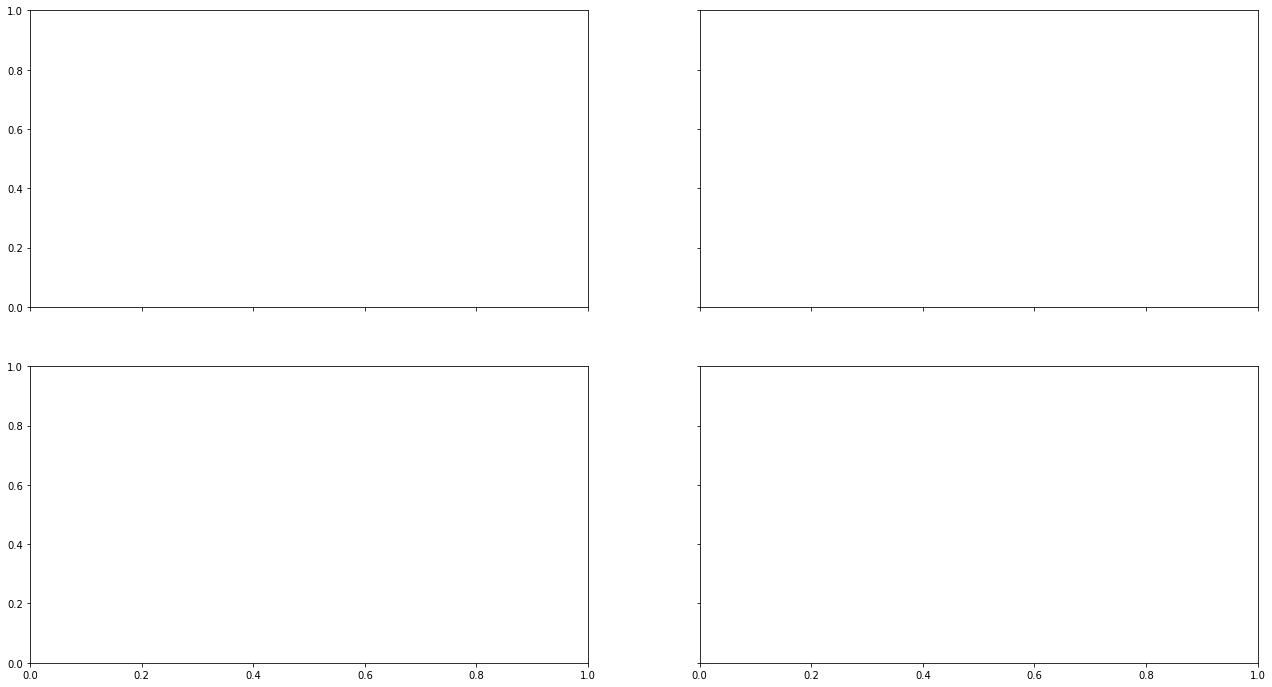

In [ ]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True,figsize=(22,12))
ax1, ax2 = axes[0]
ax3, ax4 = axes[1]

In [ ]:
ax4.plot(coba_history.history['loss'], label='Train loss')
ax4.plot(coba_history.history['val_loss'], label='Validation loss')
ax4.legend(loc='best')
ax4.set_title('CNN-LSTM')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('MSE')
plt.show()

In [ ]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True,figsize=(22,12))
ax1, ax2 = axes[0]
ax3, ax4 = axes[1]

ax1.plot(mlp_history.history['loss'], label='Train loss')
ax1.plot(mlp_history.history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('MLP')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MSE')

ax2.plot(cnn_history.history['loss'], label='Train loss')
ax2.plot(cnn_history.history['val_loss'], label='Validation loss')
ax2.legend(loc='best')
ax2.set_title('CNN')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('MSE')

ax4.plot(cnn_lstm_history.history['loss'], label='Train loss')
ax4.plot(cnn_lstm_history.history['val_loss'], label='Validation loss')
ax4.legend(loc='best')
ax4.set_title('CNN-LSTM')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('MSE')

plt.show()

In [ ]:
#Defining MAPE function
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [ ]:
mlp_train_pred = model_mlp.predict(X_train.values)
mlp_valid_pred = model_mlp.predict(X_valid.values)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, mlp_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, mlp_valid_pred)))

In [ ]:
coba_train_pred = model_coba.predict(X_train.values)
coba_valid_pred = model_coba.predict(X_valid.values)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, coba_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, coba_valid_pred)))

1487/1487 [==============================] - 35s 24ms/step
Train rmse: 14.019393743135188
Validation rmse: 13.98702817845736


In [ ]:
coba_train_pred = model_coba.predict(X_train.values)
coba_valid_pred = model_coba.predict(X_valid.values)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, coba_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, coba_valid_pred)))

1487/1487 [==============================] - 54s 36ms/step
Train rmse: 0.05290386106968984
Validation rmse: 0.05302939730740976


In [ ]:
gru_train_pred = model_GRU.predict(X_train.values)
gru_valid_pred = model_GRU.predict(X_valid.values)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, gru_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, gru_valid_pred)))

In [ ]:
plot(X_valid, Y_valid, X_valid, coba_train_pred)

In [ ]:
print('Train mape:', (MAPE(Y_train, coba_train_pred)))
print('Validation mape:', (MAPE(Y_valid, coba_valid_pred)))

NameError: ignored

In [ ]:
print('Train mape:', (MAPE(Y_train, mlp_train_pred)))
print('Validation mape:', (MAPE(Y_valid, mlp_valid_pred)))

In [ ]:
cnn_train_pred = model_cnn.predict(X_train)
cnn_valid_pred = model_cnn.predict(X_valid)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, cnn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, cnn_valid_pred)))

In [ ]:
cnn_train_pred = model_cnn.predict(X_train_series)
cnn_valid_pred = model_cnn.predict(X_valid_series)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, cnn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, cnn_valid_pred)))

In [ ]:
lstm_train_pred = model_lstm.predict(X_train_series)
lstm_valid_pred = model_cnn.predict(X_valid_series)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, lstm_valid_pred)))

In [ ]:
cnn_lstm_train_pred = model_cnn_lstm.predict(X_train_series_sub)
cnn_lstm_valid_pred = model_cnn_lstm.predict(X_valid_series_sub)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, cnn_lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, cnn_lstm_valid_pred)))